**handson用資料としての注意点**

普通、同じセル上で何度も試行錯誤するので、最終的に上手くいったセルしか残らず、失敗したセルは残りませんし、わざわざ残しません。

今回はhandson用に 試行・思考過程を残したいと思い、エラーやミスが出ても下のセルに進んで処理を実行するようにしています。

notebookのセル単位の実行ができるからこそのやり方かもしれません。良い。

（下のセルから文は常体で書きます。）

kunai (@jdgthjdg)

---


# datetime型 をindexにして時系列表示する

（グラフにした時に、x軸が日付 2008/01/03 みたいになるようにする）

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#設定でDataFrameなどが長く表示されないようにします（画面領域の消費を抑えてhandsonをしやすくするため）
# 長い場合の途中の省略表示(...)を出す閾値の設定（折り返しとは無関係）
pd.set_option('max_rows',10)
pd.set_option('max_columns',20) # これを超えたら全部は表示しない。 A B C ... X Y Z のように途中を省く。

In [2]:
df = pd.read_excel("../../../data/2008_kansai/ë╘ò▓âfü[â^2008(è╓É╝).xls", skiprows=1).iloc[:,:-2]
df.head(3)

,年,月,日,時,彦根,大津,今津,野洲,京都,舞鶴,...,神戸,西宮,篠山,山崎,奈良,吉野,大和高田,和歌山,田辺,中辺路
0,2008,2,1,1,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,4.0,0.0,8.0,0.0,NaN,0.0
1,2008,2,1,2,0.0,0.0,0.0,0.0,0.0,-9998.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN,0.0
2,2008,2,1,3,0.0,0.0,-9998.0,0.0,0.0,-9998.0,...,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,NaN,0.0


現状のグラフは下。  

dfやseriesに .plot() で簡易な折れ線グラフができる。 

y軸のマイナスの値はあとで修正する  
x軸(index)は 0から振られた番号でしかない。  
→ 何年のデータなのかが分からない。  

In [3]:
# 列(1つなので Series)の選択
df["彦根"]  # DataFrameではない。 Series(列*1 + index*1)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2899    4.0
2900    4.0
2901    4.0
2902    8.0
2903    4.0
Name: 彦根, Length: 2904, dtype: float64

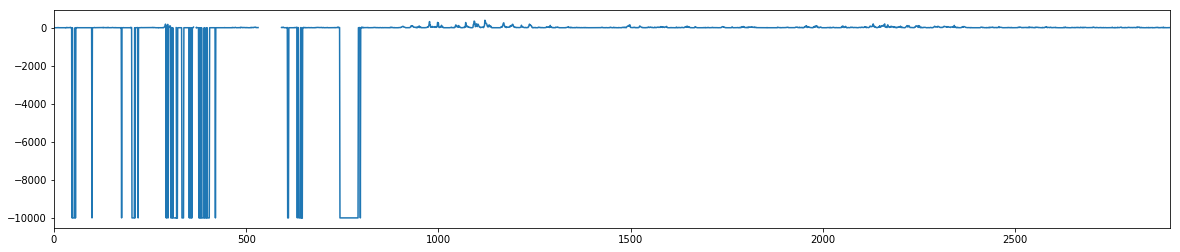

In [4]:
df[  "彦根"  ].plot(figsize=(20,4)); # 行末の ; は出力の抑制をしているだけ。消して実行すると余計なものが見える

In [5]:
df[   ["彦根"]   ]  # 最初はハマるが、リストで選択すると、複数列と判断されるので、 1列なのにSeriesではなく、 DataFrameになる
# 大げさな空白は分かりやすさのため

,彦根
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2899,4.0
2900,4.0
2901,4.0
2902,8.0


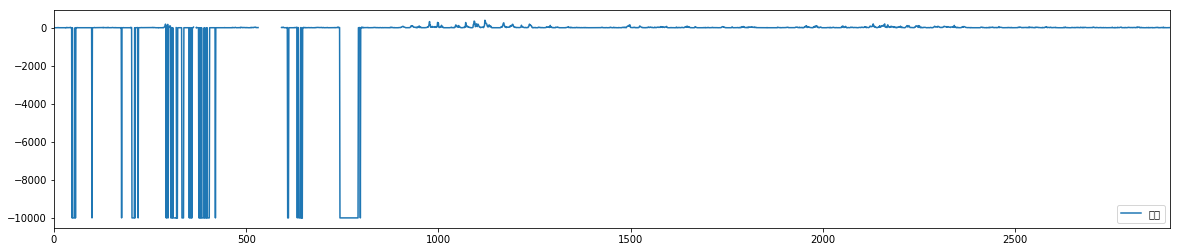

In [6]:
df[   ["彦根"]   ].plot(figsize=(20,4));  # 行末の ; は出力の抑制をしているだけ。消して実行すると余計なものが見える

# x軸を日付にしたグラフが見たい！


データを見ると、 **datetimeに必要な日付要素が、バラバラの列に格納されている（レアなデータ）**  
    
for文で横一行づつ取得して、　年・月・日・時をまとめる？  
→ これは**行単位**での演算で、pandasの得意とする処理ではない。  
**かなり遅くなる**ので最終手段にする。
    

#### pandasの得意とする処理：列単位での演算（ df[ "大津" ] + df[ "京都" ] など ）

<br>

---


<br>

### 日付データを得るために2つのパターンを出す。後述するが、 pd.to_datetime という関数を使う。

1. 最初から各列をstringに変換してから、連結して日付をつくる
2. できるだけstringを使わずに連結し、最後だけstringに変換して日付をつくる

# パターン1：最初から各列をstringに変換してから、連結して日付をつくる

いつものpythonの文字列連結のノリでやると・・・

In [7]:
"A" + "B" + "C"*3

'ABCCC'

In [8]:
df["年"]+"/"+df["月"]+"/"+df["日"]+"/"+df["時"]

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U21') dtype('<U21') dtype('<U21')

## **pd.read_XXX() したら、まず最初にデータの型(dtype)** を確認する

#### pandas で読み込んだら、まずは各列の型を見ること！
#### 希望的観測で、きっとこの型だろう！と思い込んでいると、あとあと困る・・・

In [9]:
df["年"].dtype, df["月"].dtype,df["日"].dtype,df["時"].dtype,

(dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'))

In [10]:
df.dtypes # めんどいならこっち

年         int64
月         int64
日         int64
時         int64
彦根      float64
         ...   
吉野      float64
大和高田    float64
和歌山     float64
田辺      float64
中辺路     float64
Length: 24, dtype: object

In [11]:
df.iloc[:,:5].dtypes # ilocを利用する

年       int64
月       int64
日       int64
時       int64
彦根    float64
dtype: object

int (数値)として読み込まれていたので、string に**キャスト（型の変換）** してからやってみる  
キャストは [astype](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.astype.html)


In [12]:
df["年"].head(1)  # int64

0    2008
Name: 年, dtype: int64

In [13]:
df["年"].astype(str).head(1)  # object

0    2008
Name: 年, dtype: object

**strとintの見た目が同じなので分かりにくい**  
( dtype: object になっている )

floatなら小数点が付くので分かりやすい

In [14]:
df["年"].astype(float).head(1)  # float64  .0 が付いている

0    2008.0
Name: 年, dtype: float64

### 文字列に変換したあとなら、あとはpandasが連結してくれる。 pandas 偉い。

In [15]:
str_concat = df["年"].astype(str)+"/"+df["月"].astype(str)+"/"+df["日"].astype(str)+"/"+df["時"].astype(str)
str_concat.tail(3)

2901    2008/5/31/22
2902    2008/5/31/23
2903    2008/5/31/24
dtype: object

<br>
なんとかそれっぽくなった

# datetime型として読み込む [pd.to_datetime](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)

とりあえず突っ込む

In [16]:
pd.to_datetime(str_concat)

ValueError: ('Unknown string format:', '2008/2/1/1')

"年月日時をスラッシュ区切り" という特殊なフォーマットなので、読み取り方を教えてあげる  

**format** オプション 
https://docs.python.org/ja/3.7/library/datetime.html#strftime-and-strptime-behavior

**%m(月) と %M(分) に注意**  

よく使うものは以下  
%y	西暦下2桁。	00, 01, ..., 99	 
%Y	西暦4桁 	 2013, 2014, ..., 9998, 9999	(2)
%m	0埋めした月。	01, 02, ..., 12	 

%d	0埋めした10進数で表記した月中の日にち。	01, 02, ..., 31	 
%H	0埋めした10進数で表記した時 (24時間表記)。	00, 01, ..., 23	 
%M	0埋めした10進数で表記した分。	00, 01, ..., 59	 
%S	0埋めした10進数で表記した秒。	00, 01, ..., 59	(4)
%f	10進数で表記したマイクロ秒 (左側から0埋めされます)。	000000, 000001, ..., 999999	(5)



In [17]:
pd.to_datetime(str_concat, format="%Y/%m/%d/%H")

ValueError: unconverted data remains: 4

<br>
<br>
<br>

**ValueError: unconverted data remains: 4** とでたので調べると24時が怪しい  

%H のとり得る範囲	00, 01, ..., 23	 

In [18]:
df["時_0_23"] = df["時"]-1

### df\["時"\] に上書きしない理由
df\[ "時" \] = df\[ "時" \] - 1 のように、"時" 列に上書きもできるが、ミスで複数回実行してしまった場合に、結果が変わり原因の特定に苦労しかねない。(今回のケースなら-1になってエラーが出るから気付けるが。)  

fillna() など、複数回実行しても結果が変わらない（=冪等:べきとう）操作なら上書きしてもOK（inplace というオプションもあるくらいなので）

In [19]:
str_concat_h0_23 = df["年"].astype(str)+"/"+df["月"].astype(str)+"/"+df["日"].astype(str)+"/"+df["時_0_23"].astype(str)
str_concat_h0_23.tail(3)

2901    2008/5/31/21
2902    2008/5/31/22
2903    2008/5/31/23
dtype: object

In [20]:
pd.to_datetime(str_concat_h0_23, format="%Y/%m/%d/%H")

0      2008-02-01 00:00:00
1      2008-02-01 01:00:00
2      2008-02-01 02:00:00
3      2008-02-01 03:00:00
4      2008-02-01 04:00:00
               ...        
2899   2008-05-31 19:00:00
2900   2008-05-31 20:00:00
2901   2008-05-31 21:00:00
2902   2008-05-31 22:00:00
2903   2008-05-31 23:00:00
Length: 2904, dtype: datetime64[ns]

In [21]:
df["date_hour"] = pd.to_datetime(str_concat_h0_23, format="%Y/%m/%d/%H")

無事にdatetime型にパースできた
## パターン1終わり

# パターン2：できるだけstringを使わずに連結し、最後だけstringに変換して日付をつくる

このくらいのデータなら正直変わらんけど、）百万行超えるくらいのデータになると、stringを使った処理がとても遅い！  だからintのままいじりたい！<BR>
groupbyなどで、keyを **string → int** にするだけで　**10倍速くこともよくある**

int で無理矢理やる

In [22]:
df["date_int"] = df["年"]*100*100*100 + df["月"]*100*100 + df["日"]*100 + df["時"]  # stringみたいに / で区切れないので10の倍数で位をずらす

In [23]:
pd.to_datetime(df["date_int"],format="%Y%m%d%H")  # /が無くなっている

TypeError: 'int' object is unsliceable

---
公式docを見よう
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html

int は想定外らしいのでキャストする  
objectにしてみる

In [24]:
pd.to_datetime(df["date_int"].astype("O"),format="%Y%m%d%H")

TypeError: 'int' object is unsliceable

In [25]:
e=df["date_int"].astype("O")
e[0],type(e[0]) # intのままだった

(2008020101, int)

object になっていたが、個別では intのままだったのでダメ  
strを試す

In [26]:
e=df["date_int"].astype(str)
e[0],type(e[0]) # 普通にstrで良かった

('2008020101', str)

In [27]:
pd.to_datetime(df["date_int"].astype(str),format="%Y%m%d%H")

ValueError: unconverted data remains: 4

---

1-24時ではパースできません問題  

1引いて出直します

In [28]:
df["時_0_23"] = df["時"]-1
df["時_0_23"].tail()

2899    19
2900    20
2901    21
2902    22
2903    23
Name: 時_0_23, dtype: int64

In [29]:
df["date_str"] = (df["年"]*100*100*100 + df["月"]*100*100 +df["日"]*100+df["時_0_23"]).astype(str)

In [30]:
df["date_hour"] = pd.to_datetime(df["date_str"], format="%Y%m%d%H")
df["date_hour"].head()

0   2008-02-01 00:00:00
1   2008-02-01 01:00:00
2   2008-02-01 02:00:00
3   2008-02-01 03:00:00
4   2008-02-01 04:00:00
Name: date_hour, dtype: datetime64[ns]

## パターン2終わり

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# 以上で日付(datetime) のパース完了

---


# index を datetime に変える

In [31]:
df.head(3)

,年,月,日,時,彦根,大津,今津,野洲,京都,舞鶴,...,奈良,吉野,大和高田,和歌山,田辺,中辺路,時_0_23,date_hour,date_int,date_str
0,2008,2,1,1,0.0,4.0,0.0,0.0,0.0,0.0,...,4.0,0.0,8.0,0.0,NaN,0.0,0,2008-02-01 00:00:00,2008020101,2008020100
1,2008,2,1,2,0.0,0.0,0.0,0.0,0.0,-9998.0,...,0.0,0.0,0.0,8.0,NaN,0.0,1,2008-02-01 01:00:00,2008020102,2008020101
2,2008,2,1,3,0.0,0.0,-9998.0,0.0,0.0,-9998.0,...,0.0,0.0,4.0,0.0,NaN,0.0,2,2008-02-01 02:00:00,2008020103,2008020102


In [32]:
df.index

RangeIndex(start=0, stop=2904, step=1)

今のindexは 0からの単純な整数値

indexを変えるには、 set_index もしくは df.index に直接代入すればよい

In [33]:
df.set_index("date_hour", inplace=True)
df.index

DatetimeIndex(['2008-02-01 00:00:00', '2008-02-01 01:00:00',
               '2008-02-01 02:00:00', '2008-02-01 03:00:00',
               '2008-02-01 04:00:00', '2008-02-01 05:00:00',
               '2008-02-01 06:00:00', '2008-02-01 07:00:00',
               '2008-02-01 08:00:00', '2008-02-01 09:00:00',
               ...
               '2008-05-31 14:00:00', '2008-05-31 15:00:00',
               '2008-05-31 16:00:00', '2008-05-31 17:00:00',
               '2008-05-31 18:00:00', '2008-05-31 19:00:00',
               '2008-05-31 20:00:00', '2008-05-31 21:00:00',
               '2008-05-31 22:00:00', '2008-05-31 23:00:00'],
              dtype='datetime64[ns]', name='date_hour', length=2904, freq=None)

In [34]:
df.head(2)

,年,月,日,時,彦根,大津,今津,野洲,京都,舞鶴,...,山崎,奈良,吉野,大和高田,和歌山,田辺,中辺路,時_0_23,date_int,date_str
date_hour,,,,,,,,,,,,,,,,,,,,,
2008-02-01 00:00:00,2008,2,1,1,0.0,4.0,0.0,0.0,0.0,0.0,...,4.0,4.0,0.0,8.0,0.0,NaN,0.0,0,2008020101,2008020100
2008-02-01 01:00:00,2008,2,1,2,0.0,0.0,0.0,0.0,0.0,-9998.0,...,0.0,0.0,0.0,0.0,8.0,NaN,0.0,1,2008020102,2008020101


邪魔な列(column)を消す

In [35]:
df.columns

Index(['年', '月', '日', '時', '彦根', '大津', '今津', '野洲', '京都', '舞鶴', '京北', '大阪',
       '豊中', '河内長野', '神戸', '西宮', '篠山', '山崎', '奈良', '吉野', '大和高田', '和歌山', '田辺',
       '中辺路', '時_0_23', 'date_int', 'date_str'],
      dtype='object')

In [36]:
df.drop(columns=["date_int","date_str","年","月","日","時","時_0_23"], inplace=True) # inplaceの方がメモリを食わないけど、
#df = df.drop(columns=["date_int","date_str","年","月","日","時","時_0_23"]) # こっちでも全然良い
df.head(3)

,彦根,大津,今津,野洲,京都,舞鶴,京北,大阪,豊中,河内長野,神戸,西宮,篠山,山崎,奈良,吉野,大和高田,和歌山,田辺,中辺路
date_hour,,,,,,,,,,,,,,,,,,,,
2008-02-01 00:00:00,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,8.0,0.0,NaN,0.0
2008-02-01 01:00:00,0.0,0.0,0.0,0.0,0.0,-9998.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN,0.0
2008-02-01 02:00:00,0.0,0.0,-9998.0,0.0,0.0,-9998.0,0.0,0.0,8.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,NaN,0.0


# やっとプロット

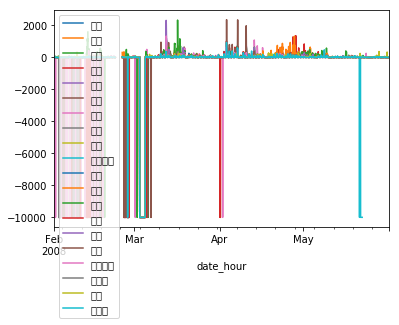

In [37]:
df.plot();

<br>

## 豆腐問題 爆誕
---

japanize_matplotlibで・・・

In [38]:
import japanize_matplotlib

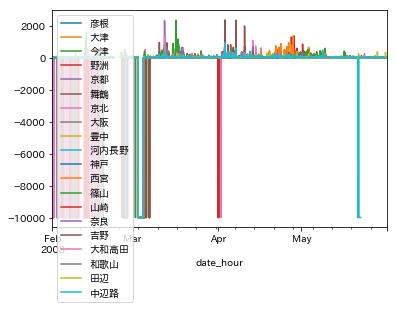

In [39]:
df.plot();

# 豆腐消えた！（たまに消えない環境も。。。）

In [40]:
import pandas as pd
df = pd.DataFrame({"height":[140, 170,160], 
                   "age":[ 12, 33, 89]})
print( df.iloc[1] ) # integer location
print( df.mean() )
print( df["age"] )

height    170
age        33
Name: 1, dtype: int64
height    156.666667
age        44.666667
dtype: float64
0    12
1    33
2    89
Name: age, dtype: int64
